## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果


In [1]:
import os
import keras
from keras.datasets import cifar10

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.np_utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [21]:
import tensorflow as tf
import keras.backend as K

"""Code Here
撰寫一個 loss function, 使其可以結合 focal loss 與 crossentropy loss
"""
def combined_loss(gamma=2., alpha=4., ce_weights = 0.7, fcl_weights = 0.3):
    gamma = float(gamma)
    alpha = float(alpha)
    def CE_focal_loss(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        """
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        
        cel_loss = keras.losses.categorical_crossentropy(y_true, y_pred)
        return (ce_weights*cel_loss)+ (fcl_weights*tf.reduce_mean(reduced_fl))
    return CE_focal_loss
ce_weights_list = [0., 0.3, 0.5, 0.7, 1]

In [22]:
import itertools
results = {}

for i, ce_w in enumerate(ce_weights_list):
    print("Numbers of exp: %i, ce_weight: %.2f" % (i, ce_w))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = tf.keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    """Code Here
    將自定義的 loss function 加入模型
    """
    model.compile(loss=combined_loss(ce_weights=ce_w, fcl_weights=1.-ce_w),
                  metrics=['accuracy'], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, ce_weight: 0.00
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                                 
 batch_normalization_21 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 hidden_layer2 (Dense)       (None, 256)               131328    
                                                                 
 batch_normalization_22 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 hidden_layer3 (Dense)  

49/49 [==============================] - 3s 60ms/step - loss: 2.4436 - accuracy: 0.5877 - val_loss: 3.2300 - val_accuracy: 0.4789
Epoch 10/25
49/49 [==============================] - 3s 58ms/step - loss: 2.3391 - accuracy: 0.6006 - val_loss: 3.1677 - val_accuracy: 0.4834
Epoch 11/25
49/49 [==============================] - 3s 62ms/step - loss: 2.2321 - accuracy: 0.6157 - val_loss: 3.2307 - val_accuracy: 0.4802
Epoch 12/25
49/49 [==============================] - 2s 51ms/step - loss: 2.1364 - accuracy: 0.6286 - val_loss: 3.1890 - val_accuracy: 0.4892
Epoch 13/25
49/49 [==============================] - 3s 51ms/step - loss: 2.0371 - accuracy: 0.6434 - val_loss: 3.1566 - val_accuracy: 0.4920
Epoch 14/25
49/49 [==============================] - 4s 88ms/step - loss: 1.9453 - accuracy: 0.6578 - val_loss: 3.2140 - val_accuracy: 0.4905
Epoch 15/25
49/49 [==============================] - 6s 119ms/step - loss: 1.8561 - accuracy: 0.6718 - val_loss: 3.2862 - val_accuracy: 0.4753
Epoch 16/25
49/49

Epoch 1/25
49/49 [==============================] - 8s 86ms/step - loss: 3.4450 - accuracy: 0.3006 - val_loss: 3.5067 - val_accuracy: 0.1713
Epoch 2/25
49/49 [==============================] - 4s 76ms/step - loss: 2.5596 - accuracy: 0.4226 - val_loss: 3.1552 - val_accuracy: 0.2668
Epoch 3/25
49/49 [==============================] - 4s 72ms/step - loss: 2.3403 - accuracy: 0.4657 - val_loss: 2.8543 - val_accuracy: 0.3466
Epoch 4/25
49/49 [==============================] - 4s 74ms/step - loss: 2.2092 - accuracy: 0.4898 - val_loss: 2.6248 - val_accuracy: 0.4002
Epoch 5/25
49/49 [==============================] - 4s 72ms/step - loss: 2.1058 - accuracy: 0.5093 - val_loss: 2.4677 - val_accuracy: 0.4358
Epoch 6/25
49/49 [==============================] - 4s 72ms/step - loss: 2.0188 - accuracy: 0.5288 - val_loss: 2.3609 - val_accuracy: 0.4551
Epoch 7/25
49/49 [==============================] - 4s 73ms/step - loss: 1.9400 - accuracy: 0.5472 - val_loss: 2.3091 - val_accuracy: 0.4657
Epoch 8/25
49

Epoch 22/25
49/49 [==============================] - 4s 80ms/step - loss: 1.0028 - accuracy: 0.6582 - val_loss: 1.4692 - val_accuracy: 0.4854
Epoch 23/25
49/49 [==============================] - 4s 79ms/step - loss: 0.9810 - accuracy: 0.6688 - val_loss: 1.4638 - val_accuracy: 0.4934
Epoch 24/25
49/49 [==============================] - 4s 77ms/step - loss: 0.9615 - accuracy: 0.6763 - val_loss: 1.4922 - val_accuracy: 0.4909
Epoch 25/25
49/49 [==============================] - 4s 79ms/step - loss: 0.9414 - accuracy: 0.6836 - val_loss: 1.4726 - val_accuracy: 0.4917


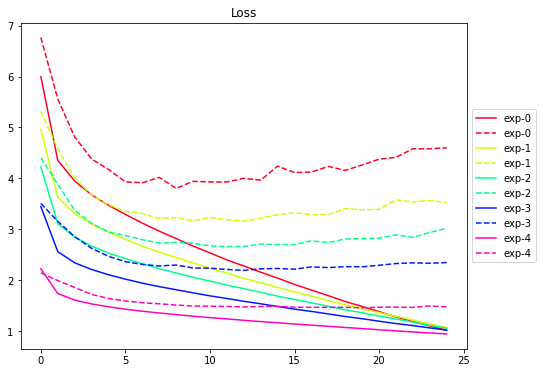

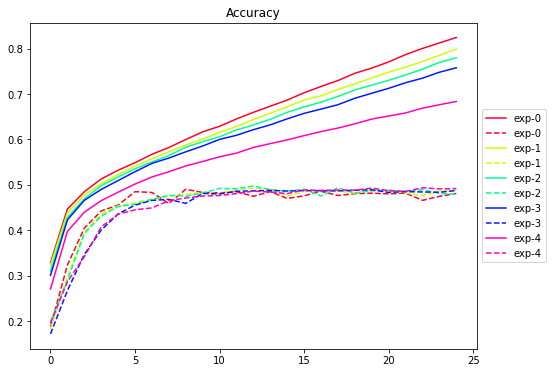

In [23]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()